In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split

2024-11-01 16:57:15.600409: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-01 16:57:20.689373: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730476642.606544 1452805 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730476643.061443 1452805 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-01 16:57:27.763399: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
time_x = np.load('s_images.npy')
time_y = np.load('s_labels.npy')
train_tx, test_tx, train_ty, test_ty = train_test_split(time_x, time_y, test_size=0.1, random_state=42)

In [ ]:
train_tx[:,1]
train_ty[:,0]

In [ ]:
K.clear_session()
input_layer = tf.keras.Input(shape=(75,75,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)

hr_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
hr_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(hr_y)
hr_y = tf.keras.layers.Dropout(0.2)(hr_y)
hr_y = tf.keras.layers.Dense(12,name='hr_y')(hr_y)

min_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
min_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(min_y)
min_y = tf.keras.layers.Dropout(0.2)(min_y)
min_y = tf.keras.layers.Dense(1,name='min_y')(min_y)

model_time = tf.keras.Model(inputs=input_layer, outputs=[hr_y, min_y])
model_time.summary()
print(model_time)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time.compile(optimizer=optimizer,
                   loss={'hr_y': loss_fn, 'min_y': 'mse'},
                   metrics={'hr_y': 'accuracy', 'min_y': 'mae'})

his_model_time = model_time.fit(train_tx, {'hr_y': train_ty[:,0], 'min_y': train_ty[:,1]/59},
                                epochs = 30, validation_split=0.1, batch_size = 100,
                                callbacks = [early_stopping,reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 75, 75, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 75, 75, 1) │          0 │ input_layer[0][0] │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 73, 73,    │      1,280 │ rescaling[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 73, 73,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 36, 36,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 34, 34,    │     36,896 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 34, 34,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 17, 17,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 15, 15,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 7, 7, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 7, 7, 64)  │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    401,536 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │    401,536 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 877,997 (3.35 MB)

 Trainable params: 877,549 (3.35 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - hr_y_accuracy: 0.0915 - hr_y_loss: 2.5570 - loss: 8.9021 - min_y_loss: 0.5973 - min_y_mae: 0.4684 - val_hr_y_accuracy: 0.0809 - val_hr_y_loss: 2.4973 - val_loss: 6.0373 - val_min_y_loss: 0.1294 - val_min_y_mae: 0.2965 - learning_rate: 5.0000e-04
Epoch 2/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - hr_y_accuracy: 0.0902 - hr_y_loss: 2.4746 - loss: 5.5133 - min_y_loss: 0.0923 - min_y_mae: 0.2506 - val_hr_y_accuracy: 0.0926 - val_hr_y_loss: 2.4851 - val_loss: 4.5742 - val_min_y_loss: 0.1319 - val_min_y_mae: 0.2934 - learning_rate: 5.0000e-04
Epoch 3/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - hr_y_accuracy: 0.1400 - hr_y_loss: 2.3778 - loss: 4.2181 - min_y_loss: 0.0804 - min_y_mae: 0.2298 - val_hr_y_accuracy: 0.1253 - val_hr_y_loss: 2.4061 - val_loss: 3.9247 - val_min_y_loss: 0.2039 - val_min_y_mae: 0.3667 - learning_rate: 5.0000e-04
Epoch 4/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - 

57/57 - 1s - 12ms/step - hr_y_accuracy: 0.8906 - hr_y_loss: 0.2900 - loss: 0.5829 - min_y_loss: 0.0307 - min_y_mae: 0.1172


[0.5829469561576843,
 0.2900250554084778,
 0.030675362795591354,
 0.8905555605888367,
 0.11719126254320145]

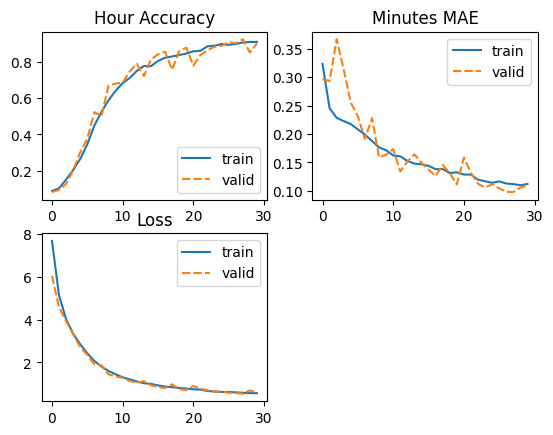

In [10]:
hr_acc_df = pd.DataFrame()
loss_df = pd.DataFrame()
min_mae_df = pd.DataFrame()
hr_acc_df['train'] = his_model_time.history['hr_y_accuracy']
hr_acc_df['valid'] = his_model_time.history['val_hr_y_accuracy']
min_mae_df['train'] = his_model_time.history['min_y_mae']
min_mae_df['valid'] = his_model_time.history['val_min_y_mae']
loss_df['train'] = his_model_time.history['loss']
loss_df['valid'] = his_model_time.history['val_loss']
fig, axs = plt.subplots(ncols=2,nrows=2)
sns.lineplot(hr_acc_df,ax=axs[0,0]).set_title("Hour Accuracy")
sns.lineplot(min_mae_df,ax=axs[0,1]).set_title("Minutes MAE")
sns.lineplot(loss_df,ax=axs[1,0]).set_title("Loss")
axs[1, 1].axis('off')
model_time.evaluate(test_tx,  {'hr_y': test_ty[:, 0], 'min_y': test_ty[:, 1] / 59}, verbose=2)